## 前準備 **ライブラリのインポートやデータ読み込み**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/handson_jleague
!pip install -q japanize-matplotlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor as RF
# データを表示する時に列を省略しないためのおまじない
pd.options.display.max_columns=None

from matplotlib import pyplot as plt
%matplotlib inline

# #日本語化matplotlibのインポート & 日本語のフォントを指定
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE

Mounted at /content/drive
/content/drive/MyDrive/handson_jleague
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# データの読み込み
train = pd.read_csv("./data/train_all.csv")
test = pd.read_csv("./data/test_all.csv")
sample = pd.read_csv("./data/sample_submit.csv",header=None)

# データ数の確認
print(train.shape)
print(test.shape)
print(sample.shape)

(1953, 43)
(313, 42)
(313, 2)


## 特長量エンジニアリング

### 月、日、曜日変換

In [3]:
#月、日、曜日を取り出す
train['MONTH']=train['gameday'].apply(lambda x: int(x[0:2]))
train["MONTH"] = train["MONTH"].astype(int)
train['day']=train['gameday'].apply(lambda x: int(x[3:5]))
train["WEEK"] = train["gameday"].apply(lambda x : x[x.find("(")+1:x.find("(")+2])
#テストデータも同様に
test['MONTH']=test['gameday'].apply(lambda x: int(x[:2]))
test["MONTH"] = test["MONTH"].astype(int)
test['day']=test['gameday'].apply(lambda x: int(x[3:5]))
test["WEEK"] = test["gameday"].apply(lambda x : x[x.find("(")+1:x.find("(")+2])

# 第１節などのカラムから数字を取り出してmatch_numに入れる
train['match_num']=train['match'].apply(lambda x: int(x[x.find("第")+1: x.find("節")]))
test['match_num']=test['match'].apply(lambda x: int(x[x.find("第")+1: x.find("節")]))

#不要カラムの削除
train=train.drop(columns=['gameday','match'])
test=test.drop(columns=['gameday','match'])

In [4]:
# WEEKデータの加工

train['WE_SAT'] = ((train['WEEK']== '土')).astype(int)
train['WE_SUN'] = ((train['WEEK']== "日")).astype(int)

test['WE_SAT'] = ((test['WEEK']== "土")).astype(int)
test['WE_SUN'] = ((test['WEEK']== "日")).astype(int)


# いらなそうなのでMONTH列削除
train = train.drop(columns='WEEK')
test = test.drop(columns='WEEK')

### チーム名変更

In [5]:
# チーム名の確認
train['home'].unique()

array(['ベガルタ仙台', '名古屋グランパス', 'ガンバ大阪', 'サンフレッチェ広島', 'コンサドーレ札幌', 'サガン鳥栖',
       '川崎フロンターレ', '大宮アルディージャ', '柏レイソル', '鹿島アントラーズ', '浦和レッズ', '横浜Ｆ・マリノス',
       'アルビレックス新潟', 'セレッソ大阪', '清水エスパルス', 'ジュビロ磐田', 'ヴィッセル神戸', 'ＦＣ東京',
       '水戸ホーリーホック', '東京ヴェルディ', 'ヴァンフォーレ甲府', 'ＦＣ岐阜', 'ファジアーノ岡山', 'アビスパ福岡',
       '大分トリニータ', 'ジェフユナイテッド千葉', '愛媛ＦＣ', '湘南ベルマーレ', 'ギラヴァンツ北九州', '栃木ＳＣ',
       'ＦＣ町田ゼルビア', '松本山雅ＦＣ', '徳島ヴォルティス', 'ザスパ草津', '横浜ＦＣ', 'ロアッソ熊本',
       '京都サンガF.C.', 'モンテディオ山形', 'ガイナーレ鳥取', 'カターレ富山', 'ザスパクサツ群馬',
       'Ｖ・ファーレン長崎', 'カマタマーレ讃岐'], dtype=object)

In [ ]:
# ザスパ草津からザスパクサツ群馬に改名していたらしいので変更
train=train.replace('ザスパ草津','ザスパクサツ群馬')
test=test.replace('ザスパ草津','ザスパクサツ群馬')

### 外れ値の処理と正規化

In [ ]:
# trainデータについて詳しく見る
train.describe()

,id,y,year,home_score,away_score,temperature,capa,MONTH,day,match_num,WE_SAT,WE_SUN
count,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000
mean,15049.442396,10629.558116,2012.820276,1.366103,1.204301,20.438914,25688.549411,6.316948,16.115207,18.050691,0.421915,0.418843
std,646.260483,8102.315189,0.758124,1.203060,1.125224,6.438737,14016.934408,2.500493,8.991773,11.153364,0.493992,0.493496
min,13994.000000,0.000000,2012.000000,0.000000,0.000000,1.400000,3560.000000,3.000000,1.000000,1.000000,0.000000,0.000000
25%,14482.000000,4687.000000,2012.000000,0.000000,0.000000,15.800000,15589.000000,4.000000,8.000000,9.000000,0.000000,0.000000
50%,15044.000000,8594.000000,2013.000000,1.000000,1.000000,21.400000,20246.000000,6.000000,17.000000,17.000000,0.000000,0.000000
75%,15532.000000,13471.000000,2013.000000,2.000000,2.000000,25.600000,30132.000000,8.000000,24.000000,27.000000,1.000000,1.000000
max,16238.000000,62632.000000,2014.000000,7.000000,8.000000,34.200000,72327.000000,12.000000,31.000000,42.000000,1.000000,1.000000


yのminが０の無観客試合はさすがに外れ値

In [6]:
#外れ値（観客数０）の除去
train=train[train['y']>0]

<Axes: ylabel='Frequency'>

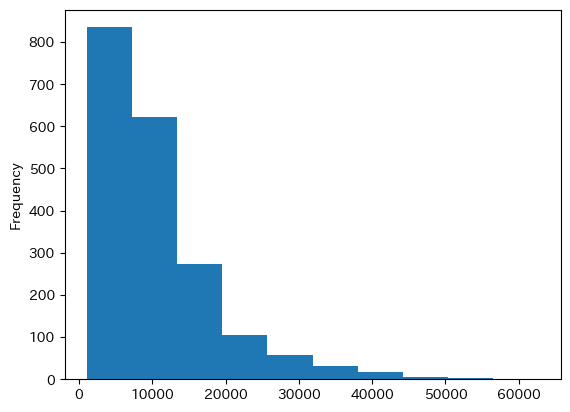

In [ ]:
# 観客動員数を棒グラフ化
train['y'].plot.hist()

**データの正規化**

元のデータの値が広い範囲に分布している場合、対数変換を使うと値のスケールを圧縮し、分布を正規分布に近づけることができます。
これにより、データが学習アルゴリズムに適した形になり、モデルの性能向上につながることがあります。

**正規化することでターゲット変数のスケールを調整し、特徴量間のバランスを取りやすくする**

<Axes: ylabel='Frequency'>

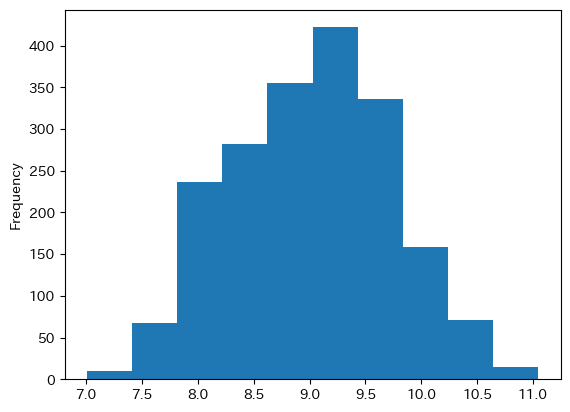

In [ ]:
#動員率予測のために対数化しないデータも取っておく
train_rate = train.copy

#log1p(numpyの関数)を適用、対数をとる
train['y']=np.log1p(train["y"])
train['y'].plot.hist()

<Axes: ylabel='Frequency'>

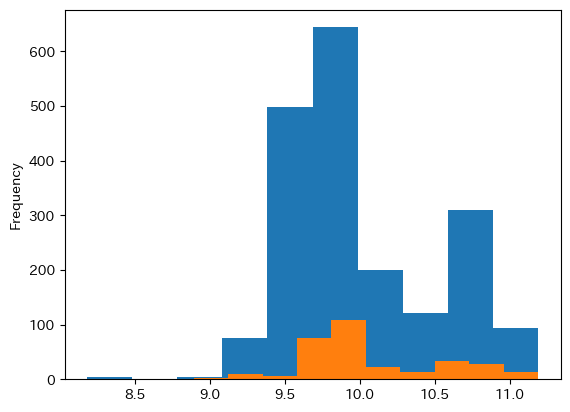

In [ ]:
# 各会場のキャパについても正規化しておく（データのスケールを整える）
train['capa']=np.log1p(train['capa'])
test['capa']=np.log1p(test['capa'])

train['capa'].plot.hist()
test['capa'].plot.hist()

### 天候表記、tv局の区別をシンプルにする

In [7]:
# 天気の表記が細かすぎるものがあるので文字列を変更
def simple_weather(weather):
  if '雪' in weather:
    return '雨'
  elif '雨' in weather:
    return '雨'
  elif '曇' in weather:
    return '曇'
  elif '晴' in weather:
    return '晴'
  else:
    return weather

train['weather_simple']=train['weather'].apply(simple_weather)
test['weather_simple']=test['weather'].apply(simple_weather)
print(train['weather_simple'].value_counts())

weather_simple
晴     969
曇     583
雨     345
屋内     55
Name: count, dtype: int64


In [8]:
# テレビ局を番号で分かるように変換
train["tv_num"] = train["tv"].apply(lambda x : len(x.split("／")))
test["tv_num"] = test["tv"].apply(lambda x : len(x.split("／")))

## データフレームをいじる


### selectデータの作成、ダミー変数化など

In [33]:
# 制度に大きく影響のありそうなデータを選んで新しいデータフレームを作る
train_select=train[['capa','WE_SAT','WE_SUN','stage','MONTH','home','away','weather_simple','tv_num']]
test_select=test[['capa','WE_SAT','WE_SUN','stage','MONTH','home','away','weather_simple','tv_num']]

In [34]:
# 対数化
train['y']=np.log1p(train["y"])
train_select['capa']=np.log1p(train_select['capa'])
test_select['capa']=np.log1p(test_select['capa'])

<ipython-input-34-0425ca54a1bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_select['capa']=np.log1p(train_select['capa'])
<ipython-input-34-0425ca54a1bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_select['capa']=np.log1p(test_select['capa'])


In [35]:
#一時的にデータを結合
# 結合前にtrainというフラグを作り、trainデータは1、testデータは0とする
train_select["train"]=1
test_select["train"]=0

# 結合
full_df = pd.concat([train_select, test_select],sort=False)

# ダミー変数化（ワンホットエンコーディング）
full_df = pd.get_dummies(full_df)

# trainフラグが1のものをtrain_selectとする。
train_select = full_df[full_df["train"]==1]
# trainフラグを削除
train_select = train_select.drop(columns="train")

# trainフラグが0のものをtest_selectとする。その後、trainフラグを削除
test_select = full_df[full_df["train"]==0]
test_select = test_select.drop(columns="train")

<ipython-input-35-20f7e769686b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_select["train"]=1
<ipython-input-35-20f7e769686b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_select["train"]=0


### モデル作成、精度確認のためのデータフレーム変更

In [36]:
# カラム数の一致を確認（カラム数違うとモデル作成でエラー出る）
print(train_select.shape)
print(test_select.shape)

(1952, 97)
(313, 97)


In [37]:
# 学習データを訓練とテストに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_select, train['y'], random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1464, 97)
(488, 97)
(1464,)
(488,)


# モデル作成


## 重回帰モデル
### モデルの選定をもっとやれば精度高まる？

In [38]:
from sklearn.linear_model import LinearRegression

# LinearRegression クラスのインスタンスを作成
lr = LinearRegression()

# データに対して学習を実行
lr.fit(X_train, y_train)

LinearRegression()

In [39]:
# 各特徴量が目的変数に与える影響を可視化
coef_df =pd.DataFrame(lr.coef_, index=X_train.columns, columns=['Coefficients'])
pd.options.display.float_format="{:.4f}".format #表示を少数4桁まで
print(coef_df)
print('Intercept: ', lr.intercept_ )

                   Coefficients
capa                     0.4416
WE_SAT                   0.1445
WE_SUN                   0.1664
MONTH                    0.0182
tv_num                   0.0270
...                         ...
away_Ｖ・ファーレン長崎          -0.0437
weather_simple_屋内        0.0904
weather_simple_晴         0.0363
weather_simple_曇         0.0003
weather_simple_雨        -0.1270

[97 rows x 1 columns]
Intercept:  4.2610977794405756


In [40]:
y_pred_train = lr.predict(X_train)
print(y_pred_train)

[ 8.10721496  8.58164341  9.40320207 ... 10.64482142  8.29767448
  9.12652098]


In [41]:
# 正規化したものを元に戻したい
y_train_output = np.expm1(y_train)# 訓練データの目的変数yを指数化
y_pred_train_output = np.expm1(y_pred_train) # 訓練データの予測結果を指数化

In [42]:
# RMSEで評価
from sklearn.metrics import mean_squared_error as MSE
rmse_train = np.sqrt(MSE(y_train_output, y_pred_train_output))
print(rmse_train)

3162.2874971216143


In [43]:
# trainのテストデータでもRMSE評価
y_pred_test=lr.predict(X_test)
y_test_output = np.expm1(y_test)
y_pred_test_output = np.expm1(y_pred_test)

rmse_test = np.sqrt(MSE(y_test_output,y_pred_test_output))
print(rmse_test)

3349.5790716585657


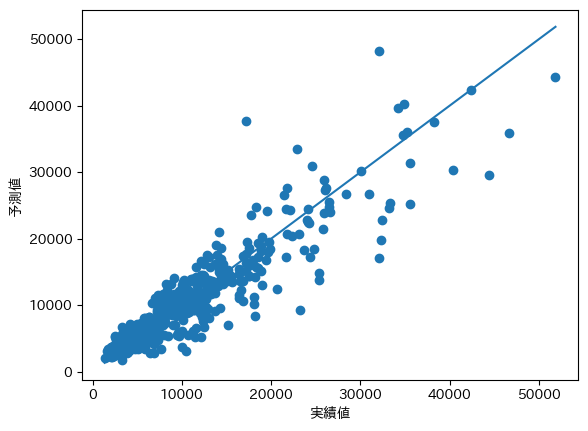

In [ ]:
# 散布図で可視化
plt.scatter(y_test_output, y_pred_test_output)
min_value = min(y_test_output.min(), y_pred_test_output.min())
max_value = max(y_test_output.max(), y_pred_test_output.max())

plt.plot([min_value,max_value],[min_value,max_value])

plt.xlabel('実績値')
plt.ylabel('予測値')
plt.show()
# 対角線の上側の点は予測値が実績値を超えた点　下側の点は実績値より低く予想してしまった点　線に沿って点が多いほど良い

In [ ]:
predict = lr.predict(test_select)
predict_out = np.expm1(predict)

sample[1]=predict_out
sample.to_csv('model/LR_simple.csv' ,header=None, index=False)

## 残差分析
モデルの妥当性を検証　残差の傾向やとびぬけた値の無を調べる

In [ ]:
# X_trainに予測値のカラムを追加
X_train['pred'] = y_pred_train
# 実測値ー予測値
X_train['res'] = y_train - y_pred_train

# X_testに関しても同様にカラムを追加
X_test['pred'] = y_pred_test
X_test['res'] = y_test -y_pred_test

In [ ]:
tmp = pd.concat([X_train, X_test])
train_check = pd.concat([train, tmp[['pred','res']]], axis=1)

#残差が大きい順に表示
x = train_check.sort_values(by = 'res', ascending = False)
x.head(20)

,id,y,year,stage,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,home_08,home_09,home_10,home_11,away_team,away_01,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11,address,capa,MONTH,day,WEEK,match_num,weather_simple,tv_num,pred,res
1703,15989,9.2517,2014,Ｊ２,13:03,カマタマーレ讃岐,ジュビロ磐田,香川県立丸亀競技場,スカパー！／スカパー！プレミアムサービス,1,4,晴,13.6000,44%,岡 宏道,カマタマーレ讃岐,瀬口 拓弥,持留 新作,西野 泰正,野口 遼太,沼田 圭悟,岡村 和哉,綱田 大志,山本 翔平,アンドレア,高木 和正,我那覇 和樹,ジュビロ磐田,藤ヶ谷 陽介,駒野 友一,菅沼 駿哉,伊野波 雅彦,宮崎 智彦,フェルジナンド,藤田 義明,松井 大輔,ポポ,山崎 亮平,前田 遼一,香川県丸亀市金倉町830,10.0141,3,9,日,2,晴,2,8.0586,1.1930
1446,15514,9.2165,2013,Ｊ２,14:33,東京ヴェルディ,ジェフユナイテッド千葉,駒沢オリンピック公園総合運動場陸上競技場,スカパー！／スカパー！プレミアムサービス,1,0,曇時々晴,23.6000,42%,福島 孝一郎,東京ヴェルディ,佐藤 優也,井林 章,吉野 恭平,石神 直哉,森 勇介,鈴木 惇,小池 純輝,中後 雅喜,飯尾 一慶,高原 直泰,巻 誠一郎,ジェフユナイテッド千葉,岡本 昌弘,米倉 恒貴,キム ヒョヌン,山口 智,高橋 峻希,佐藤 勇人,佐藤 健太郎,伊藤 大介,田中 佑昌,ケンペス,森本 貴幸,東京都世田谷区駒沢公園1-1,9.9040,9,23,月,34,曇,2,8.2129,1.0037
1679,15812,10.0553,2014,Ｊ１,19:04,サガン鳥栖,川崎フロンターレ,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス,0,1,曇,29.2000,77%,松尾 一,サガン鳥栖,林 彰洋,丹羽 竜平,菊地 直哉,キム ミンヒョク,安田 理大,早坂 良太,岡本 知剛,藤田 直之,金 民友,池田 圭,豊田 陽平,川崎フロンターレ,杉山 力裕,小宮山 尊信,實藤 友紀,谷口 彰悟,登里 享平,大島 僚太,中村 憲剛,森谷 賢太郎,金久保 順,小林 悠,大久保 嘉人,佐賀県鳥栖市京町812,10.1061,7,23,水,16,曇,2,9.1355,0.9198
578,14572,8.8348,2012,Ｊ２,19:04,ザスパクサツ群馬,ＦＣ町田ゼルビア,正田醤油スタジアム群馬,スカパー／ｅ２／スカパー光,1,1,曇,21.8000,80%,井上 知大,ザスパクサツ群馬,北 一真,星野 悟,中村 英之,御厨 貴文,永田 拓也,小林 竜樹,熊林 親吾,櫻田 和樹,林 勇介,遠藤 敬佑,金 成勇,ＦＣ町田ゼルビア,修行 智仁,三鬼 海,薗田 淳,田代 真一,藤田 泰成,太田 康介,加藤 恒平,コリン マーシャル,鈴木 崇文,平本 一樹,ドラガン ディミッチ,群馬県前橋市敷島町66,9.6248,7,22,日,25,曇,3,7.9201,0.9147
1891,16177,9.4740,2014,Ｊ２,18:05,ＦＣ岐阜,Ｖ・ファーレン長崎,岐阜メモリアルセンター長良川競技場,スカパー！／スカパー！プレミアムサービス,1,1,曇,25.0000,64%,佐藤 隆治,ＦＣ岐阜,川口 能活,益山 司,阿部 正紀,木谷 公亮,三都主 アレサンドロ,ヘニキ,宮沢 正史,太田 圭輔,髙地 系治,美尾 敦,ナザリト,Ｖ・ファーレン長崎,大久保 択生,下田 光平,山口 貴弘,髙杉 亮太,神崎 大輔,前田 悠佑,奥埜 博亮,石神 直哉,東 浩史,佐藤 洸一,イ デホン,岐阜県岐阜市長良福光大野2675-28,9.9035,6,21,土,19,曇,2,8.5596,0.9144
1202,15270,9.6173,2013,Ｊ２,16:03,東京ヴェルディ,横浜ＦＣ,味の素スタジアム,スカパー！／スカパー！プレミアムサービス,1,3,晴,17.0000,43%,前田 拓哉,東京ヴェルディ,佐藤 優也,金 鐘必,刀根 亮輔,石神 直哉,森 勇介,鈴木 惇,小池 純輝,西 紀寛,飯尾 一慶,常盤 聡,高原 直泰,横浜ＦＣ,シュナイダー 潤之介,武岡 優斗,ペ スンジン,野上 結貴,森本 良,寺田 紳一,松下 裕樹,小野瀬 康介,野崎 陽介,大久保 哲哉,三浦 知良,東京都調布市西町376-3,10.8192,5,3,金,12,晴,2,8.7186,0.8987
1689,15975,9.4461,2014,Ｊ２,13:04,東京ヴェルディ,松本山雅ＦＣ,味の素スタジアム,スカパー！／スカパー！プレミアムサービス,1,3,曇時々雨,5.8000,67%,井上 知大,東京ヴェルディ,佐藤 優也,安西 幸輝,吉野 恭平,金 鐘必,舘野 俊祐,田村 直也,中後 雅喜,前田 直輝,高木 大輔,菅嶋 弘希,平本 一樹,松本山雅ＦＣ,村山 智彦,田中 隼磨,犬飼 智也,飯田 真輝,岩沼 俊介,多々良 敦斗,岩上 祐三,喜山 康平,鐡戸 裕史,船山 貴之,サビア,東京都調布市西町376-3,10.8192,3,2,日,1,雨,2,8.5961,0.8500
1803,16089,9.4023,2014,Ｊ２,14:03,東京ヴェルディ,ＦＣ岐阜,国立競技場,スカパー！／スカパー！プレミアムサービス,0,1,晴,26.7000,33%,上田 益也,東京ヴェルディ,佐藤 優也,安西 幸輝,金 鐘必,井林 章,安在 和樹,田村 直也,吉野 恭平,中後 雅喜,鈴木 惇,常盤 聡,平本 一樹,ＦＣ岐阜,川口 能活,野垣内 俊,阿部 正紀,関田 寛士,三都主 アレサンドロ,ヘニキ,宮沢 正史,太田 圭輔,髙地 系治,難波 宏明,ナザリト,東京都新宿区霞ヶ丘町10,10.9009,5,3,土,11,晴,2,8.5646,0.8377
1756,16042,8.7653,2014,Ｊ２,13:04,ザスパクサツ群馬,水戸ホーリーホック,正田醤油スタジアム群馬,スカパー！／スカパー！プレミアムサービス／群馬テレビ,0,1,晴,18.9000,19%,上田 益也,ザスパクサツ群馬,内藤 圭佑,夛田 凌輔,小柳 達司,クォン ハンジン,瀬川 和樹,青木 孝太,加藤 弘堅,黄 誠秀,永田 亮太,ダニエル ロビーニョ,小林 竜樹,水戸ホーリーホック,本間 幸司,新里 亮,冨田 大介,尾本 敬,広瀬 陸斗,小澤 司,中里 崇宏,内田 航平,船谷 圭祐,吉田 眞紀人,三島 康平,群馬県前橋市敷島町66,9.6248,4,13,日,7,晴,3,7.9613,0.8040
653,14647,10.0698,2012,Ｊ２,18:05,大分トリニータ,ヴァンフォーレ甲府,大分銀行ドーム,スカパー／ｅ２／スカパー光,1,2,曇,26.4000,73%,家本 政明,大分トリニータ,清水 圭介,松原 健,阪田 章裕,安川 有,三平 和司,丸谷 拓也,宮沢 正史,石神 直哉,西 弘則,為田 大貴,森島 康仁,ヴァンフォーレ甲府,荻 晃太,福田 健介,津田 琢磨,盛田 剛平,佐々木 翔,山本 英臣,柏 好文,保坂 一成,井澤 惇,フェルナンジーニョ,ダヴィ,大分県大分市大字横尾1351,10.5967,9,2,日,32,曇,3,9.2700,0.7998


### MONTHの加工

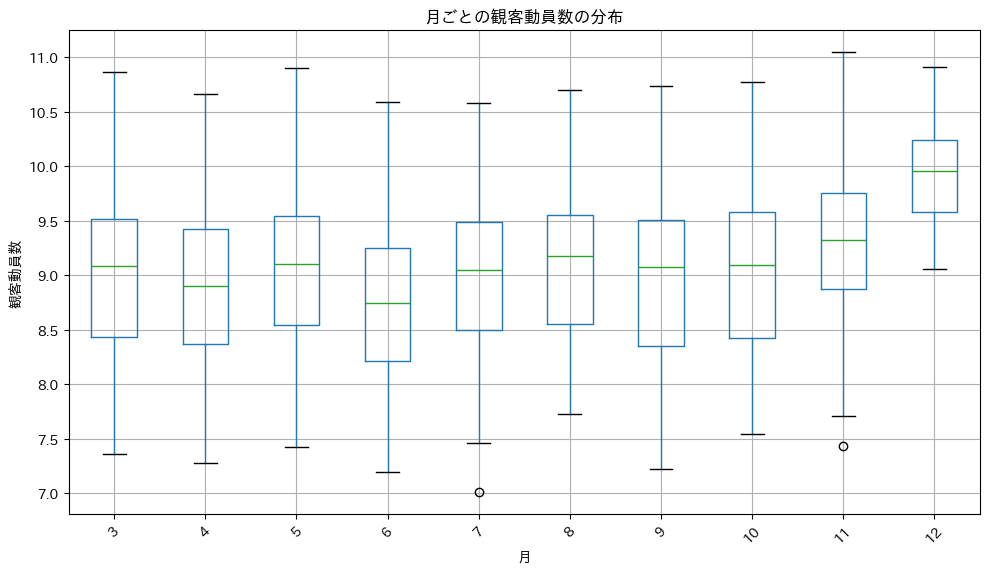

In [ ]:
import matplotlib.pyplot as plt

# プロットの準備
fig, ax = plt.subplots(1, 1, figsize=(10, 6))  # プロットは1つだけなので (1, 1) に変更

# 箱ひげ図の作成
train.boxplot(column="y", by="MONTH", rot=45, ax=ax)  # 'by' で月ごとに分ける
ax.set_title("月ごとの観客動員数の分布")
ax.set_xlabel("月")
ax.set_ylabel("観客動員数")

plt.suptitle("")  # デフォルトのタイトルを削除
plt.tight_layout()
plt.show()


１２月がとびぬけて多く、１１月も少し多そう
ほかの月はあまり影響していない？

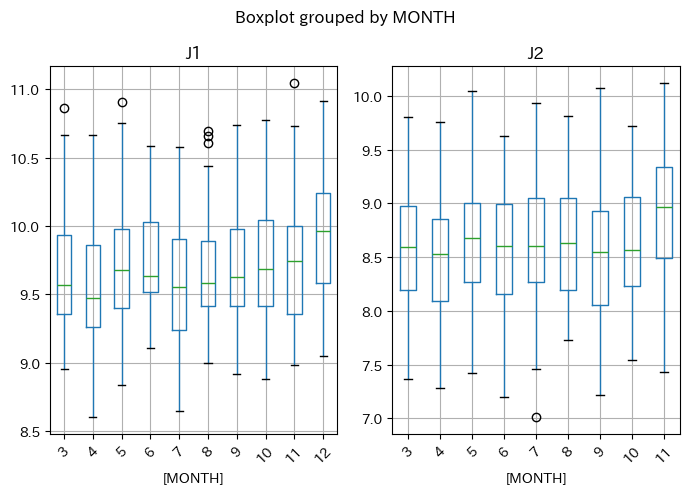

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(7,5))
train[train["stage"]=="Ｊ１"][["MONTH","y"]].boxplot(by="MONTH",rot=45,ax=ax[0])
train[train["stage"]=="Ｊ２"][["MONTH","y"]].boxplot(by="MONTH",rot=45,ax=ax[1])
ax[0].set_title("J1")
ax[1].set_title("J2")
plt.tight_layout()

１2は１２月に試合がなくて、J1しかないので多くなっている
11月が多い理由はJ2が終りに近くなり動員数が増加するため　なのでJ1はそこまで変わらないはず　それを判断してもらう

In [44]:
# MONTHデータの加工
# J1の試合で11月の試合１２月の試合、J2の試合で11月の試合を判定するカラムの作成
train_select['J1_Nov'] = ((train_select['stage_Ｊ１']== 1)&(train_select['MONTH']==11)).astype(int)
train_select['J1_Dec'] = ((train_select['stage_Ｊ１']== 1)&(train_select['MONTH']==12)).astype(int)
train_select['J2_Nov'] = ((train_select['stage_Ｊ２']== 1)&(train_select['MONTH']==11)).astype(int)
test_select['J1_Nov'] = ((test_select['stage_Ｊ１']== 1)&(test_select['MONTH']==11)).astype(int)
test_select['J1_Dec'] = ((test_select['stage_Ｊ１']== 1)&(test_select['MONTH']==12)).astype(int)
test_select['J2_Nov'] = ((test_select['stage_Ｊ２']== 1)&(test_select['MONTH']==11)).astype(int)

# いらなそうなのでMONTH列削除
train_select = train_select.drop(columns='MONTH')
test_select = test_select.drop(columns='MONTH')

## 再度モデル作成評価　3009!
行ったこと：MONTHの加工

In [45]:
#一時的にデータを結合
# 結合前にtrainというフラグを作り、trainデータは1、testデータは0とする
train_select["train"]=1
test_select["train"]=0

# 結合
full_df = pd.concat([train_select, test_select],sort=False)

# ダミー変数化（ワンホットエンコーディング）
full_df = pd.get_dummies(full_df)

# trainフラグが1のものをtrainXとする。その後、trainフラグを削除
train_select = full_df[full_df["train"]==1]
train_select = train_select.drop(columns="train")

# trainフラグが0のものをtestXとする。その後、trainフラグを削除
test_select = full_df[full_df["train"]==0]
test_select = test_select.drop(columns="train")

In [46]:
# カラム数の一致を確認（カラム数違うとモデル作成でエラー出る）
print(train_select.shape)
print(test_select.shape)

# 学習データを訓練とテストに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_select, train['y'], random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1952, 99)
(313, 99)
(1464, 99)
(488, 99)
(1464,)
(488,)


In [47]:
from sklearn.linear_model import LinearRegression

# LinearRegression クラスのインスタンスを作成
lr = LinearRegression()

# データに対して学習を実行
lr.fit(X_train, y_train)

LinearRegression()

In [48]:
# 訓練データの予測
y_pred_train = lr.predict(X_train)
y_train_output = np.expm1(y_train)# 訓練データの目的変数yを指数化
y_pred_train_output = np.expm1(y_pred_train) # 訓練データの予測結果を指数化

# テストデータの評価
y_pred_test=lr.predict(X_test)
y_test_output = np.expm1(y_test)
y_pred_test_output = np.expm1(y_pred_test)

# RMSEで評価
rmse_train = np.sqrt(MSE(y_train_output, y_pred_train_output))
rmse_test = np.sqrt(MSE(y_test_output,y_pred_test_output))
print("rmse_train :"+str(rmse_train))
print("rmse_test : "+str(rmse_test))

rmse_train :3134.2200901027213
rmse_test : 3339.9028222991574


## 対数化していないver

In [ ]:
# 対数化していないver
# RMSEで評価
from sklearn.metrics import mean_squared_error as MSE
rmse_train = np.sqrt(MSE(y_train, y_pred_train))
print(rmse_train)

3102.7653379738795


In [ ]:
# 対数化していないver
# trainのテストデータでもRMSE評価
y_pred_test=lr.predict(X_test)

rmse_test = np.sqrt(MSE(y_test,y_pred_test))
print(rmse_test)

3336.225184444371


In [ ]:
# モデルの保存
predict = lr.predict(test_select)

sample[1]=predict
sample.to_csv('model/LR_simple.csv' ,header=None, index=False)

In [21]:
# 対数化しないver
# 訓練データの予測
y_pred_train = lr.predict(X_train)

# テストデータの評価
y_pred_test=lr.predict(X_test)

# RMSEで評価
rmse_train = np.sqrt(MSE(y_train, y_pred_train))
rmse_test = np.sqrt(MSE(y_test,y_pred_test))
print("rmse_train :"+str(rmse_train))
print("rmse_test : "+str(rmse_test))

rmse_train :3082.6065554701036
rmse_test : 3359.955118300001


In [22]:
# 対数化していないver
predict = lr.predict(test_select)

sample[1]=predict
sample.to_csv('model/LR_simple4_Notaisu.csv' ,header=None, index=False)

In [ ]:
train_select.head(3)

,capa,WE_SAT,WE_SUN,tv_num,stage_Ｊ１,stage_Ｊ２,home_アビスパ福岡,home_アルビレックス新潟,home_カターレ富山,home_カマタマーレ讃岐,home_ガイナーレ鳥取,home_ガンバ大阪,home_ギラヴァンツ北九州,home_コンサドーレ札幌,home_サガン鳥栖,home_サンフレッチェ広島,home_ザスパクサツ群馬,home_ジェフユナイテッド千葉,home_ジュビロ磐田,home_セレッソ大阪,home_ファジアーノ岡山,home_ベガルタ仙台,home_モンテディオ山形,home_ロアッソ熊本,home_ヴァンフォーレ甲府,home_ヴィッセル神戸,home_京都サンガF.C.,home_名古屋グランパス,home_大分トリニータ,home_大宮アルディージャ,home_川崎フロンターレ,home_徳島ヴォルティス,home_愛媛ＦＣ,home_東京ヴェルディ,home_松本山雅ＦＣ,home_柏レイソル,home_栃木ＳＣ,home_横浜Ｆ・マリノス,home_横浜ＦＣ,home_水戸ホーリーホック,home_浦和レッズ,home_清水エスパルス,home_湘南ベルマーレ,home_鹿島アントラーズ,home_ＦＣ岐阜,home_ＦＣ東京,home_ＦＣ町田ゼルビア,home_Ｖ・ファーレン長崎,away_アビスパ福岡,away_アルビレックス新潟,away_カターレ富山,away_カマタマーレ讃岐,away_ガイナーレ鳥取,away_ガンバ大阪,away_ギラヴァンツ北九州,away_コンサドーレ札幌,away_サガン鳥栖,away_サンフレッチェ広島,away_ザスパクサツ群馬,away_ジェフユナイテッド千葉,away_ジュビロ磐田,away_セレッソ大阪,away_ファジアーノ岡山,away_ベガルタ仙台,away_モンテディオ山形,away_ロアッソ熊本,away_ヴァンフォーレ甲府,away_ヴィッセル神戸,away_京都サンガF.C.,away_名古屋グランパス,away_大分トリニータ,away_大宮アルディージャ,away_川崎フロンターレ,away_徳島ヴォルティス,away_愛媛ＦＣ,away_東京ヴェルディ,away_松本山雅ＦＣ,away_柏レイソル,away_栃木ＳＣ,away_横浜Ｆ・マリノス,away_横浜ＦＣ,away_水戸ホーリーホック,away_浦和レッズ,away_清水エスパルス,away_湘南ベルマーレ,away_鹿島アントラーズ,away_ＦＣ岐阜,away_ＦＣ東京,away_ＦＣ町田ゼルビア,away_Ｖ・ファーレン長崎,weather_simple_屋内,weather_simple_晴,weather_simple_曇,weather_simple_雨,J1_Nov,J1_Dec,J2_Nov
0,9.8881,1,0,4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,0,0,0
1,10.5967,1,0,4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,0,0,0
2,9.9523,1,0,4,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,0,0


# train:test=8:2にした時の変化を見る

In [ ]:
#8:2
from sklearn.model_selection import train_test_split
X_train8, X_test8, y_train8, y_test8= train_test_split(train_select, train['y'],test_size=0.2, random_state=0)
print(X_train8.shape)
print(X_test8.shape)
print(y_train8.shape)
print(y_test8.shape)

(1561, 102)
(391, 102)
(1561,)
(391,)


In [ ]:
# 8:2
from sklearn.linear_model import LinearRegression

# LinearRegression クラスのインスタンスを作成
lr = LinearRegression()

# データに対して学習を実行
lr.fit(X_train8, y_train8)

LinearRegression()

In [ ]:
# 訓練データの予測
y_pred_train8 = lr.predict(X_train8)
y_train_output8 = np.expm1(y_train8)# 訓練データの目的変数yを指数化
y_pred_train_output8 = np.expm1(y_pred_train8) # 訓練データの予測結果を指数化

# テストデータの評価
y_pred_test8=lr.predict(X_test8)
y_test_output8 = np.expm1(y_test8)
y_pred_test_output8 = np.expm1(y_pred_test8)

# RMSEで評価
rmse_train8 = np.sqrt(MSE(y_train_output8, y_pred_train_output8))
rmse_test8 = np.sqrt(MSE(y_test_output8,y_pred_test_output8))
print(rmse_train8)
print(rmse_test8)

3107.4373058074502
3276.51383798155


# ファイル出力

In [49]:
predict = lr.predict(test_select)
predict_out = np.expm1(predict)

In [ ]:
predict = lr.predict(test_select)
predict_out = np.expm1(predict)

sample[1]=predict_out
sample.to_csv('model/LR_simple3.csv' ,header=None, index=False)

# LightGBM

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# Initialize the LightGBM model
lgbm = LGBMRegressor(random_state=0)

# Define the parameter grid
param_grid = {
    'n_estimators': [300, 500, 1000, 3000, 5000, 7000],
    'learning_rate': [0.01, 0.1, 0.3,  0.5, 0.7],
    'max_depth': [2, 3, 5]
}

# Create a GridSearch object
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

# Train and evaluate the model with the best parameters
lgbm_best = LGBMRegressor(**best_params)
lgbm_best.fit(X_train, y_train)

# 訓練データの予測
y_pred_train = lgbm_best.predict(X_train)
y_train_output = np.expm1(y_train) # 訓練データの目的変数yを指数化
y_pred_train_output = np.expm1(y_pred_train) # 訓練データの予測結果を指数化

# テストデータの予測
y_pred_test = lgbm_best.predict(X_test)
y_test_output = np.expm1(y_test) # テストデータの目的変数yを指数化
y_pred_test_output = np.expm1(y_pred_test) # テストデータの予測結果を指数化

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [ ]:
predict = lgbm_best.predict(test_select)
predict_out = np.expm1(predict)

sample[1]=predict_out

import os

def count_up_and_save(sample, model_type='LGBM', directory='model/'):
    # ディレクトリが存在しない場合は作成
    if not os.path.exists(directory):
        os.makedirs(directory)

    # バージョン番号を決定
    version = 1
    while True: # ver番号で前回ファイルより1大きい数字で作成でき
        file_path = os.path.join(directory, f'{model_type}_ver{version}.csv')
        if not os.path.exists(file_path):  # ファイルが存在しなければそのバージョンを採用
            break
        version += 1

    # データをCSVに保存
    sample.to_csv(file_path, header=None, index=False)
    print(f"Saved to {file_path}")

# 呼び出し
count_up_and_save(sample)

Saved to model/LGBM_ver8.csv


# 動員率予測

## LR

In [26]:
# 動員率の計算
train["attendance_rate"] = train['y'] / train["capa"]

y_rate = train["attendance_rate"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_select, y_rate, random_state=0)

# モデルの構築と学習
lr_model = LR()
lr_model.fit(X_train, y_train)

# 予測（学習データとテストデータ）
pred_train_rate = lr_model.predict(X_train)
pred_test_rate = lr_model.predict(X_test)

# 予測値の最小値が動員率の最小値よりも小さかった場合、最小値で置換
min_rate = train["attendance_rate"].min()
pred_train_rate[pred_train_rate < min_rate] = min_rate
pred_test_rate[pred_test_rate < min_rate] = min_rate


# RMSEで評価
rmse_train = np.sqrt(MSE(y_train, pred_train_rate))
rmse_test = np.sqrt(MSE(y_test,pred_test_rate))
print("rmse_train :"+str(rmse_train))
print("rmse_test : "+str(rmse_test))

rmse_train :0.09991785783836037
rmse_test : 0.11560248099948695


In [28]:
# 動員率→動員数を計算
# pred_rate: 動員率の予測結果
# test["capa"]: 各試合の最大収容人数

#投稿用データの予測（動員率を予測）
lr_test_pred_rate = lr_model.predict(test_select)

# 動員率から動員数を求める
pred_attendance = lr_test_pred_rate  * test["capa"]

# 動員数を整数に丸める（必要に応じて）
pred_attendance = pred_attendance.round().astype(int)

sample[1]=pred_attendance
sample.to_csv('./model/LR_3009_rate.csv' ,header=None, index=False)


In [ ]:
predict = lr.predict(test_select)
predict_out = np.expm1(predict)

sample[1]=predict_out
sample.to_csv('model/LR_simple3.csv' ,header=None, index=False)

In [50]:
# 動員率からの予測値と動員数からの予測値の平均を計算
average_pred = (pred_attendance + predict_out) / 2

sample[1]=average_pred
sample.to_csv('./model/LR_figure_rate_average.csv' ,header=None, index=False)

動員率予測からの残渣分析

In [31]:
# X_trainに予測値のカラムを追加
X_train['pred'] = pred_train_rate
# 実測値ー予測値
X_train['res'] = y_train - pred_train_rate

# X_testに関しても同様にカラムを追加
X_test['pred'] = pred_test_rate
X_test['res'] = y_test -pred_test_rate

In [32]:
tmp = pd.concat([X_train, X_test])
train_check = pd.concat([train, tmp[['pred','res']]], axis=1)

#残差が大きい順に表示
x = train_check.sort_values(by = 'res', ascending = False)
x.head(20)

,id,y,year,stage,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,home_03,home_04,home_05,home_06,home_07,home_08,home_09,home_10,home_11,away_team,away_01,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11,address,capa,MONTH,day,match_num,WE_SAT,WE_SUN,weather_simple,tv_num,attendance_rate,pred,res
1059,15127,62632,2013,Ｊ１,14:04,横浜Ｆ・マリノス,アルビレックス新潟,日産スタジアム,スカパー！／スカパー！プレミアムサービス／ＮＨＫ総合,0,2,晴,12.7,33%,家本 政明,横浜Ｆ・マリノス,榎本 哲也,小林 祐三,栗原 勇蔵,中澤 佑二,ドゥトラ,中町 公祐,富澤 清太郎,兵藤 慎剛,中村 俊輔,齋藤 学,マルキーニョス,アルビレックス新潟,東口 順昭,三門 雄大,舞行龍ジェームズ,大井 健太郎,金 珍洙,レオ シルバ,成岡 翔,田中 亜土夢,岡本 英也,田中 達也,川又 堅碁,神奈川県横浜市港北区小机町3300,72327,11,30,33,1,0,晴,3,0.865956,0.392966,0.472990
1679,15812,23277,2014,Ｊ１,19:04,サガン鳥栖,川崎フロンターレ,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス,0,1,曇,29.2,77%,松尾 一,サガン鳥栖,林 彰洋,丹羽 竜平,菊地 直哉,キム ミンヒョク,安田 理大,早坂 良太,岡本 知剛,藤田 直之,金 民友,池田 圭,豊田 陽平,川崎フロンターレ,杉山 力裕,小宮山 尊信,實藤 友紀,谷口 彰悟,登里 享平,大島 僚太,中村 憲剛,森谷 賢太郎,金久保 順,小林 悠,大久保 嘉人,佐賀県鳥栖市京町812,24490,7,23,16,0,0,曇,2,0.950470,0.478092,0.472378
618,14612,7637,2012,Ｊ２,18:03,ギラヴァンツ北九州,アビスパ福岡,北九州市立本城陸上競技場,スカパー／ｅ２／スカパー光,4,2,晴,30.2,65%,佐藤 隆治,ギラヴァンツ北九州,佐藤 優也,川鍋 良祐,金 鐘必,キローラン 木鈴,多田 高行,新井 涼平,木村 祐志,鈴木 慎吾,安田 晃大,端戸 仁,池元 友樹,アビスパ福岡,神山 竜一,和田 拓三,古賀 正紘,小原 章吾,キム ミンジェ,鈴木 惇,岡田 隆,城後 寿,木原 正和,坂田 大輔,西田 剛,福岡県北九州市八幡西区御開4-16-1,10202,8,19,29,0,1,晴,3,0.748579,0.328994,0.419585
953,15021,22530,2013,Ｊ１,19:03,サガン鳥栖,大宮アルディージャ,ベストアメニティスタジアム,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１,2,1,晴,31.1,56%,高山 啓義,サガン鳥栖,林 彰洋,丹羽 竜平,呂 成海,菊地 直哉,金 民友,水沼 宏太,藤田 直之,高橋 義希,早坂 良太,池田 圭,豊田 陽平,大宮アルディージャ,北野 貴之,今井 智基,菊地 光将,高橋 祥平,下平 匠,渡邉 大剛,青木 拓矢,上田 康太,曺 永哲,ノヴァコヴィッチ,ズラタン,佐賀県鳥栖市京町812,24490,8,17,21,1,0,晴,3,0.919967,0.509992,0.409975
1632,15765,38966,2014,Ｊ１,19:04,名古屋グランパス,セレッソ大阪,豊田スタジアム,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／名古屋テレビ（録）,1,2,晴,17.8,33%,山本 雄大,名古屋グランパス,楢﨑 正剛,矢野 貴章,ハーフナー ニッキ,田中 マルクス闘莉王,本多 勇喜,枝村 匠馬,田口 泰士,中村 直志,小川 佳純,玉田 圭司,永井 謙佑,セレッソ大阪,武田 博行,染谷 悠太,藤本 康太,酒本 憲幸,山下 達也,扇原 貴宏,山口 蛍,南野 拓実,丸橋 祐介,柿谷 曜一朗,フォルラン,愛知県豊田市千石町7-2,40000,5,3,11,1,0,晴,4,0.974150,0.577740,0.396410
1089,15157,18153,2013,Ｊ２,13:03,Ｖ・ファーレン長崎,ガンバ大阪,長崎県立総合運動公園陸上競技場,スカパー！／スカパー！プレミアムサービス,1,3,曇,19.6,56%,福島 孝一郎,Ｖ・ファーレン長崎,岩丸 史也,藤井 大輔,山口 貴弘,髙杉 亮太,小笠原 侑生,井上 裕大,岩間 雄大,古部 健太,神崎 大輔,幸野 志有人,佐藤 洸一,ガンバ大阪,藤ヶ谷 陽介,丹羽 大輝,岩下 敬輔,今野 泰幸,藤春 廣輝,明神 智和,遠藤 保仁,阿部 浩之,二川 孝広,平井 将生,倉田 秋,長崎県諫早市宇都町27-1,20246,3,10,2,0,1,曇,2,0.896622,0.506388,0.390234
1468,15536,7058,2013,Ｊ２,16:03,ギラヴァンツ北九州,アビスパ福岡,北九州市立本城陸上競技場,スカパー！／スカパー！プレミアムサービス,0,2,晴,26.0,70%,扇谷 健司,ギラヴァンツ北九州,武田 博行,宮本 亨,渡邉 将基,前田 和哉,多田 高行,新井 純平,八角 剛史,井上 翔太,小手川 宏基,渡 大生,池元 友樹,アビスパ福岡,神山 竜一,パク ゴン,古賀 正紘,堤 俊輔,岡田 隆,中原 秀人,三島 勇太,オ チャンヒョン,金森 健志,プノセバッチ,坂田 大輔,福岡県北九州市八幡西区御開4-16-1,10202,10,6,36,0,1,晴,2,0.691825,0.319604,0.372221
1266,15334,11482,2013,Ｊ２,17:03,横浜ＦＣ,ガイナーレ鳥取,ニッパツ三ツ沢球技場,スカパー！／スカパー！プレミアムサービス,2,1,晴,21.9,56%,日高 晴樹,横浜ＦＣ,シュナイダー 潤之介,武岡 優斗,ペ スンジン,野上 結貴,森下 俊,佐藤 謙介,松下 裕樹,寺田 紳一,内田 智也,黒津 勝,大久保 哲哉,ガイナーレ鳥取,杉本 拓也,林堂 眞,横竹 翔,柳楽 智和,尾崎 瑛一郎,鮫島 晃太,田中 雄大,森 英次郎,住田 貴彦,久保 裕一,永里 源気,神奈川県横浜市神奈川区三ツ沢西町3-1,15454,6,8,18,1,0,晴,2,0.742979,0.379130,0.363849
1442,15510,3369,2013,Ｊ２,13:04,ＦＣ岐阜,ガイナーレ鳥取,大垣市浅中公園総合グラウンド陸上競技場,スカパー！／スカパー！プレミアムサービス,2,1,晴,30.7,50%,野田 祐樹,ＦＣ岐阜,時久 省吾,杉山 新,木谷 公亮,新井 辰也,野垣内 俊,染矢 一樹,森安 洋文,服部 年宏,美尾 敦,中村 祐輝,スティッペ,ガイナーレ鳥取,小針 清允,森 英次郎,柳楽 智和,柳川 雅樹,ドゥドゥ,奥山 泰裕,実信 憲明,林堂 眞,廣田 隆治,辻 正男,久保 裕一,岐阜県大垣市浅中2-11-1,4300,9,22,34,0,1,晴,2,0.783488,0.427083,0.356405
685,14679,3016,2012,Ｊ２,19:04,ＦＣ岐阜,湘南ベルマーレ,岐阜メモリアルセンター長良川球技メドウ,スカパー／ｅ２／スカパー光,3,2,晴,21.4,66%,早川 一行,ＦＣ岐阜,時久 省吾,野垣内 俊,田中 秀人,関田 寛士,尾泉 大樹,井上 平,李 漢宰,服部 年宏,染矢 一樹,樋口 寛規,佐藤 洸一,湘南ベルマーレ,阿部 伸行,鎌田 翔雅,遠藤 航,大野 和成,猪狩 佑貴,岩上 祐三,永木 亮太,高山 薫,菊池 大介,大槻 周平,古橋 達弥,岐阜県岐阜市長良福光青襖2070-7,3560,9,23,35,0,1,晴,3,0.847191,0.505860,0.341332
